## Downstream Task: Pascal

Now that we've pretrained a network to fill in image patches, let's create a task that will allow us to benchmark how well our pretext task works. We can imagine a variety of downstream tasks including segmentation, objection detection and classification across a range of image distributions including natural photographs or medical images.

To keep things simple for now, we'll just try image classification on the Pascal VOC dataset.

In [1]:
import json

from collections import Set
import numpy as np
import pandas as pd

from fastai2.basics import DataBlock, RandomSplitter

from fastai2.vision.all import ImageBlock, PILMask, get_image_files, PILImage, imagenet_stats
from fastai2.vision.core import get_annotations, Image, TensorBBox, TensorPoint, TensorImage
from fastai2.vision.augment import aug_transforms, RandomResizedCrop, RandTransform
from fastai2.vision.learner import unet_learner, unet_config

from fastai2.vision.data import ImageDataBunch
from fastai2.data.block import MultiCategoryBlock
from fastai2.data.transforms import Normalize
from fastai2.data.external import download_url, URLs, untar_data

from torch.nn import MSELoss
from torchvision.models import resnet34

/home/josh/anaconda3/envs/fastai2/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
pascal_path = untar_data(URLs.PASCAL_2012)
pascal_path

Path('/home/josh/.fastai/data/pascal_2012')

In [3]:
train_json = json.load(pascal_path/'train.json')

In [4]:
# trn_fns
# training_filenames
IMAGES,ANNOTATIONS,CATEGORIES = 'images', 'annotations', 'categories'
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {o[ID]:o['name'] for o in train_json[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in train_json[IMAGES]}

In [5]:
image_to_category = {}
for annotation in train_json[ANNOTATIONS]:
    img_id = annotation['image_id']
    category_id = annotation['category_id'] - 1 # categories are 1-indexed
    filename = trn_fns[img_id]
    
    if filename not in image_to_category:
        image_to_category[filename] = set()
        
    image_to_category[filename].add(category_id)

In [6]:
# Create one row for each image, one column for each class
targets = np.zeros((len(trn_fns), len(cats)), dtype=np.int)

# Put 1 for every class present in a given image
for i, image in enumerate(sorted(trn_fns.values())):
    categories = image_to_category[image]
    
    for category in categories:
        targets[i, category] = 1

In [7]:
train_df = pd.DataFrame(targets)
train_df['filename'] = sorted(trn_fns.values())

train_df.columns = list(cats.values()) + ['filename']
train_df = train_df.set_index('filename')
train_df = train_df.reset_index()

In [8]:
train_df

,filename,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,diningtable,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor
0,2008_000008.jpg,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,2008_000015.jpg,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2008_000019.jpg,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2008_000023.jpg,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,2008_000028.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5712,2011_003253.jpg,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5713,2011_003255.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5714,2011_003259.jpg,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
5715,2011_003274.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [9]:
train_df.columns

Index(['filename', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
       'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
       'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
       'tvmonitor'],
      dtype='object')

In [10]:
data = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=lambda o: o)

In [11]:
databunch = ImageDataBunch.from_df(train_df, 
                                   path=pascal_path/'train',
                                   fn_col=0,
                                   bs=8,
                                   item_tfms=[RandomResizedCrop(160)], #TODO: Not crop, just resize
                                   batch_tfms=[*aug_transforms(size=160, max_warp=0, max_rotate=0)])
                                  

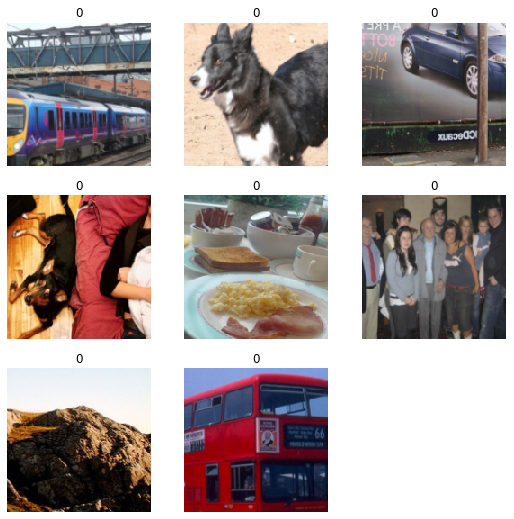

In [12]:
# TODO: Figure out multi-label databunch labels. 
# They seem wrong right now. Probably have to fix it during databunch creation
databunch.show_batch(max_n=9)

In [13]:
# TODO Load learner that was trained on pretext task

In [14]:
# TODO fine tune on this task

In [15]:
# TODO gauge performance